In [1]:
"""
CS 281. Homework 1 2025. Machine Bias

Your code and short answers will go into this file. 
"""
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns


## A. Machine Bias (6 points)


### A1. The COMPAS model predicted a defendant’s risk of recidivism to inform decisions on bail, parole, and sentencing. It impacted thousands by assigning biased scores that led to unfair outcomes, particularly for Black defendants.

### A2. I’d be concerned about sampling bias—if the dataset underrepresents minorities or reflects biased policing, the model may perform worse on those groups. Additionally, outcome labels like “reoffended” may reflect systemic bias rather than true criminal behavior.

### A3. ProPublica found that the COMPAS algorithm was biased against Black defendants, who were nearly twice as likely as whites to be incorrectly labeled high risk, despite similar rates of reoffending.

## B. Broward County dataset (17 points)

In [2]:
## Load the COMPAS Dataset
raw_data = pd.read_csv('compas-scores-two-years.csv')
print('Num rows: %d' % len(raw_data))

# what are the column names? What do they mean?
print(raw_data.columns)

## browse it
raw_data.head()



Num rows: 7214
Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


### B1. Pre-processing


In [3]:
# ## Apply the filtering described in question B.1 of hw1.pdf.
# ## df should be a pandas.DataFrame object

df = raw_data[raw_data['days_b_screening_arrest'].abs() <= 30]
print('Q1: Num data points after filtering: %d' % len(df))

Q1: Num data points after filtering: 6172


### B2. Demographics

In [5]:
## Count the number of individuals across racial identities, age categories and
# binary sex categories. Report your numbers.

# Count by race
print("Race counts:")
print(df['race'].value_counts())
print()

# Count by age category
print("Age category counts:")
print(df['age_cat'].value_counts())
print()

# Count by sex
print("Sex counts:")
print(df['sex'].value_counts())

Race counts:
race
African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: count, dtype: int64

Age category counts:
age_cat
25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: count, dtype: int64

Sex counts:
sex
Male      4997
Female    1175
Name: count, dtype: int64


### B3. Distribution of COMPAS scores


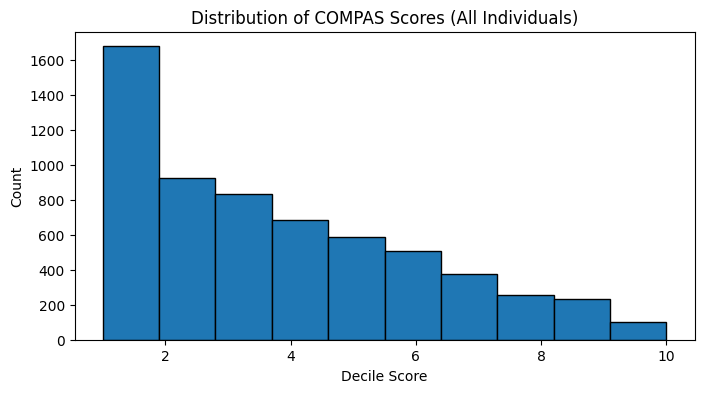

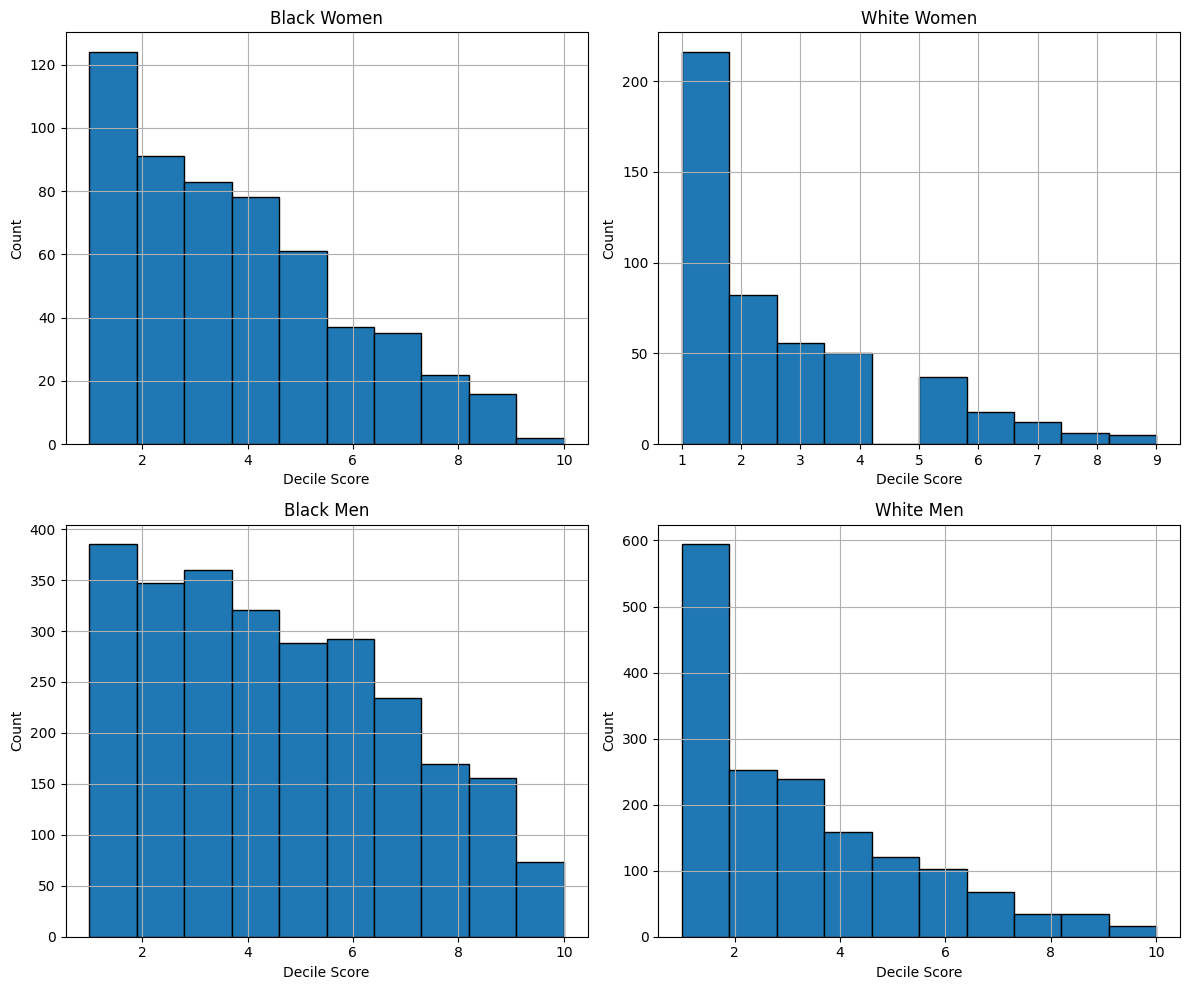

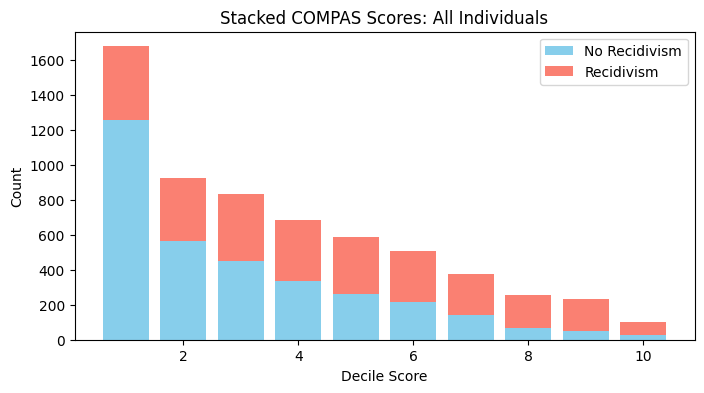

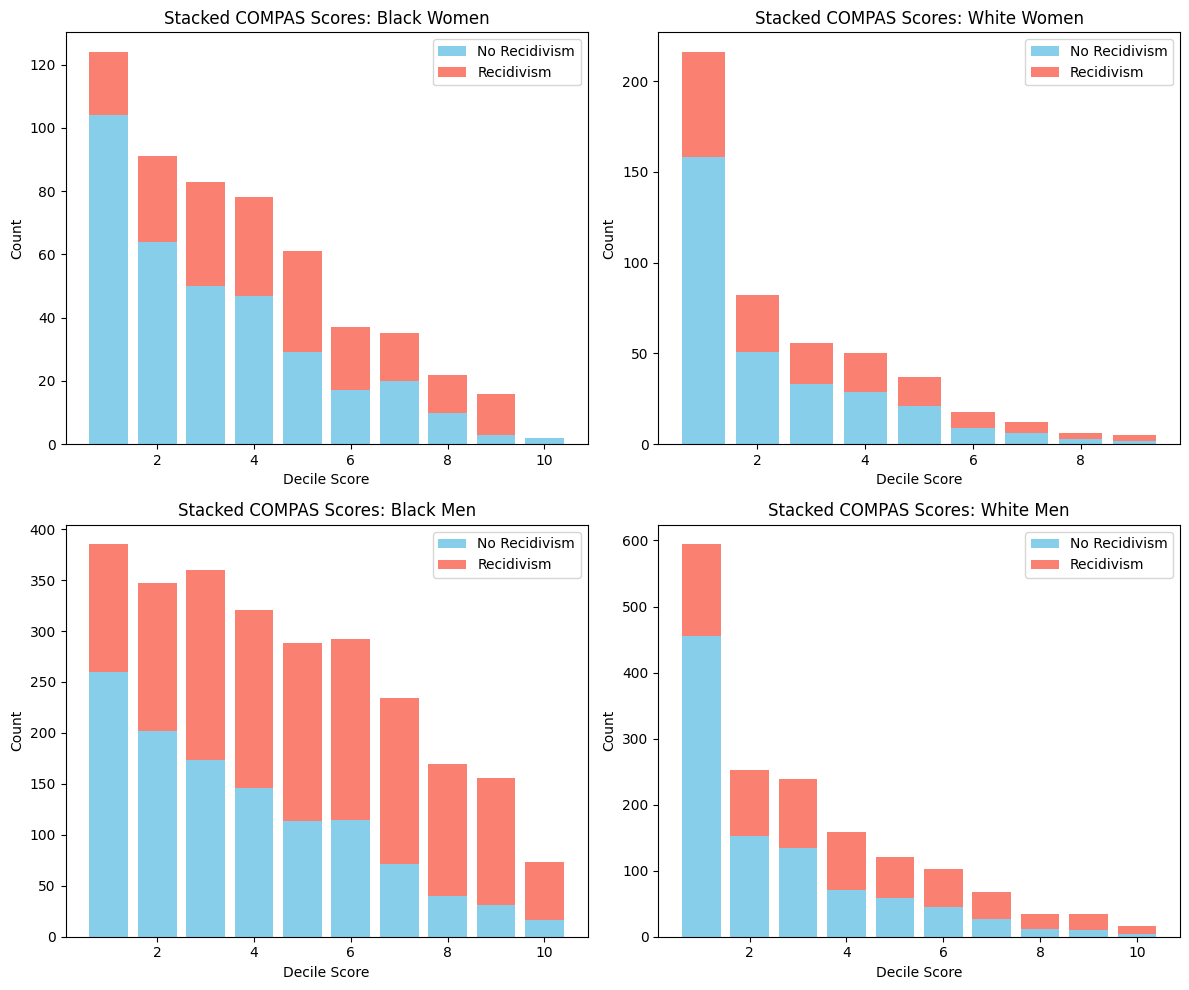

In [8]:
# a. Plot the distribution of scores for all individuals (a single histogram)
plt.figure(figsize=(8, 4))
df['v_decile_score'].hist(bins=10, edgecolor='black')
plt.title('Distribution of COMPAS Scores (All Individuals)')
plt.xlabel('Decile Score')
plt.ylabel('Count')
plt.grid(False)
plt.show()

# b. Plot the distribution of scores for (four separate histograms): 
# Black women, white women, Black men, white men
groups = {
    'Black Women': df[(df['race'] == 'African-American') & (df['sex'] == 'Female')],
    'White Women': df[(df['race'] == 'Caucasian') & (df['sex'] == 'Female')],
    'Black Men': df[(df['race'] == 'African-American') & (df['sex'] == 'Male')],
    'White Men': df[(df['race'] == 'Caucasian') & (df['sex'] == 'Male')],
}

plt.figure(figsize=(12, 10))
for i, (group_name, group_df) in enumerate(groups.items(), 1):
    plt.subplot(2, 2, i)
    group_df['v_decile_score'].hist(bins=10, edgecolor='black')
    plt.title(f'{group_name}')
    plt.xlabel('Decile Score')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

# c. Repeat the plots, this time using stacked bars: color-coding the proportion
# of each bar corresponding to individuals who did vs did not recidivate 
# (two_year_recid == 0 in one color, two_year_recid == 1 in another).
# Hint: find pointers for creating stacked bars here https://www.pythoncharts.com/python/stacked-bar-charts/
def plot_stacked_bar(data, title):
    recid_0 = data[data['two_year_recid'] == 0]['v_decile_score'].value_counts().sort_index()
    recid_1 = data[data['two_year_recid'] == 1]['v_decile_score'].value_counts().sort_index()
    all_scores = sorted(set(recid_0.index).union(set(recid_1.index)))

    recid_0 = recid_0.reindex(all_scores, fill_value=0)
    recid_1 = recid_1.reindex(all_scores, fill_value=0)

    plt.bar(all_scores, recid_0, label='No Recidivism', color='skyblue')
    plt.bar(all_scores, recid_1, bottom=recid_0, label='Recidivism', color='salmon')
    plt.title(title)
    plt.xlabel('Decile Score')
    plt.ylabel('Count')
    plt.legend()

# Entire population
plt.figure(figsize=(8, 4))
plot_stacked_bar(df, 'Stacked COMPAS Scores: All Individuals')
plt.show()

# 4 groups
plt.figure(figsize=(12, 10))
for i, (group_name, group_df) in enumerate(groups.items(), 1):
    plt.subplot(2, 2, i)
    plot_stacked_bar(group_df, f'Stacked COMPAS Scores: {group_name}')
plt.tight_layout()
plt.show()


### d. 
I noticed that the overall distribution is skewed toward higher risk scores for Black individuals, especially Black men, who have higher proportions of recidivism-labeled scores compared to all the other groups and the general plot. Moreover, White defendants are more frequently assigned lower risk scores compared to Black individuals. We can see that Black women receive higher scores in general compared to white women and the same can be observed comparing black men and white men in both the colored and the general plots. Therefore we can see that Black men and women make up more of the general recidivism in the general plot. The stacked plots show that Black defendants are more likely to be labeled high risk even when they do not reoffend, revealing a potential racial bias in the COMPAS model. 

### B4. Reflection point. 
#### a. 
According to the U.S. Census, Black individuals represent 13% of the county, but they make up over 60% of the dataset (3175 out of ~6172). This shows the dataset significantly over-represents Black individuals.

#### b. 
Black men and women have distributions skewed toward higher COMPAS scores, while white individuals, especially white women, have distributions skewed heavily toward low scores. Black men are disproportionately assigned high-risk scores compared to other groups.

#### c. 
ProPublica’s dataset substantially overrepresents Black individuals, who make up 13% of Broward County's population but constitute over 60% of the COMPAS dataset. In contrast, groups such as Asian and Native American individuals are starkly underrepresented. This imbalance likely results from systemic policing practices that disproportionately target Black communities—such as higher rates of surveillance, stops, arrests, and charges in majority-Black neighborhoods—which inflates their presence in criminal datasets. Additionally, bias may be embedded in the data collection process itself: variables used in the COMPAS score can act as proxies for race and socioeconomic status. 

#### d. 
Using this dataset to train a new model risks reinforcing systemic biases, as it overrepresents Black individuals due to historically disproportionate policing. The model may learn misleading associations between race and recidivism, leading to unfairly high risk scores for Black defendants. Since recidivism is defined by re-arrest rather than actual reoffending, the model could conflate police presence with criminal behavior, perpetuating unjust outcomes.

## C. Fairness metrics of COMPAS scores

For consistency with ProPublica’s analysis, we will assume that the decision threshold is at COMPAS risk 5 - in other words, that all individuals in the low risk category are recommended for release (d=0), but all individuals in the medium and high risk categories are not (d=1). 

Hint: add a binary column to your data frame that corresponds to this binary decision.


### C1. Intuition behind fairness metrics

#### a. Add your latex expression to the second column, Statistical Property, and a brief sentence in the third column.

| Metric Name      | Statistical property | If this metric is satisfied, we can be sure that |
| ----------- | ----------- | ----------- |
| Independence        | $$ d \perp c$$ |  The predicted decision d (release/do not release) is statistically independent of the protected attribute c (e.g., race), meaning no group is systematically favored. |
| Separation - FNR    | $$d \perp c \mid y = 1 $$ | Among individuals who actually reoffended, the false negative rate is the same across groups (e.g., no group is more likely to be incorrectly deemed low risk).  |
| Separation - FPR    | $$ d \perp c \mid y = 0 $$ |  Among individuals who did not reoffend, the false positive rate is equal across groups (e.g., no group is unfairly labeled as high risk). |
| Sufficiency - PPR   | $$ y \perp c \mid d$$ | For any given predicted risk category, the actual recidivism rate is the same across groups (e.g., COMPAS predictions are equally reliable for all races).  |

#### b. Separation is more relevant here because it directly addresses whether individuals who did or did not reoffend are being treated differently across racial groups. ProPublica showed that Black defendants had much higher false positive rates than white defendants, leading to unjust outcomes. Sufficiency does not work well in this context because it only ensures that predicted risk scores correlate equally with actual outcomes across groups, but it ignores whether the types of errors (false positives/negatives) are distributed fairly—which is crucial when those errors lead to real-world consequences like incarceration.

### C2. Calculations
For each of the following fairness metrics, calculate the appropriate statistic for 5 variants of the data: (1) all individuals, (2) Black women, (3) white women, (4) Black men, (5) white men. Assume the decision threshold of 5 in all cases except for sufficiency (using decile scores).

* Independence.
* Separation - false negative rate
* Separation - false positive rate
* Sufficiency - using decile scores
* Sufficiency - using binary decisions


In [15]:
# Filter to Black and White individuals and create a copy
df_bw = df[df['race'].isin(['African-American', 'Caucasian'])].copy()

# Binarize decision and recidivism columns safely
df_bw['d'] = (df_bw['v_decile_score'].astype(int) >= 5).astype(int)
df_bw['y'] = df_bw['two_year_recid'].astype(int)

# Group definitions
groups = {
    'All': df_bw,
    'Black Women': df_bw[(df_bw['race'] == 'African-American') & (df_bw['sex'] == 'Female')],
    'White Women': df_bw[(df_bw['race'] == 'Caucasian') & (df_bw['sex'] == 'Female')],
    'Black Men': df_bw[(df_bw['race'] == 'African-American') & (df_bw['sex'] == 'Male')],
    'White Men': df_bw[(df_bw['race'] == 'Caucasian') & (df_bw['sex'] == 'Male')],
}

#### Independence

In [16]:
df_bw.groupby('race')['d'].mean()

race
African-American    0.436535
Caucasian           0.216358
Name: d, dtype: float64

#### Separation - false negative rate

In [17]:
def compute_fnr(group):
    return ((group['d'] == 0) & (group['y'] == 1)).sum() / (group['y'] == 1).sum()

for label, g in groups.items():
    print(f"{label}: FNR = {compute_fnr(g):.3f}")

All: FNR = 0.526
Black Women: FNR = 0.547
White Women: FNR = 0.782
Black Men: FNR = 0.433
White Men: FNR = 0.661


#### Separation - false positive rate

In [18]:
def compute_fpr(group):
    return ((group['d'] == 1) & (group['y'] == 0)).sum() / (group['y'] == 0).sum()

for label, g in groups.items():
    print(f"{label}: FPR = {compute_fpr(g):.3f}")

All: FPR = 0.238
Black Women: FPR = 0.234
White Women: FPR = 0.131
Black Men: FPR = 0.331
White Men: FPR = 0.161


#### Sufficiency - using decile scores

In [19]:
for label, g in groups.items():
    print(f"\n{label}:\n", g.groupby('v_decile_score')['y'].mean().round(3))


All:
 v_decile_score
1     0.259
2     0.393
3     0.472
4     0.517
5     0.560
6     0.587
7     0.644
8     0.725
9     0.783
10    0.758
Name: y, dtype: float64

Black Women:
 v_decile_score
1     0.161
2     0.297
3     0.398
4     0.397
5     0.525
6     0.541
7     0.429
8     0.545
9     0.812
10    0.000
Name: y, dtype: float64

White Women:
 v_decile_score
1    0.269
2    0.378
3    0.411
4    0.420
5    0.432
6    0.500
7    0.500
8    0.500
9    0.600
Name: y, dtype: float64

Black Men:
 v_decile_score
1     0.325
2     0.418
3     0.519
4     0.545
5     0.604
6     0.606
7     0.697
8     0.765
9     0.801
10    0.781
Name: y, dtype: float64

White Men:
 v_decile_score
1     0.232
2     0.399
3     0.439
4     0.551
5     0.512
6     0.563
7     0.597
8     0.686
9     0.714
10    0.750
Name: y, dtype: float64


#### Sufficiency - using binary decisions

In [20]:
def compute_ppv(group):
    return ((group['d'] == 1) & (group['y'] == 1)).sum() / (group['d'] == 1).sum()

for label, g in groups.items():
    print(f"{label}: PPV = {compute_ppv(g):.3f}")

All: PPV = 0.639
Black Women: PPV = 0.532
White Women: PPV = 0.474
Black Men: PPV = 0.681
White Men: PPV = 0.586


### C3. Interpretation. 
a. Independence: The probability of receiving a high-risk score (d = 1) is much higher for Black defendants (43.7%) than for white defendants (21.6%). This indicates a strong dependency between race and the predicted decision, suggesting the model does not satisfy independence and treats racial groups unequally.

b.  Separation

    i. false negative rate: White women have the highest FNR (0.782), meaning they are most likely to be misclassified as low risk even when they reoffend. In contrast, Black men have the lowest FNR (0.433), indicating the model is more likely to correctly identify recidivism for them. This suggests the model is more forgiving toward white women.

    
    ii. false positive rate: Black men have the highest FPR (0.331), while white men have the lowest (0.061). This shows that Black men are more frequently mislabeled as high risk despite not reoffending—leading to unjust detainment or harsher decisions. This asymmetry reflects the bias emphasized in ProPublica’s findings.



c. Sufficiency (positive predictive value)

    i. using decile scores: The overall PPV is 0.639, but Black men have a higher PPV (0.681) while white women are much lower (0.474). This shows that the score is more calibrated for Black men—high scores more often correspond to actual recidivism—while the model may overpredict risk for white women, reducing fairness across groups.
    
    ii. using binary decisions: Looking at the decile scores, white women show relatively flat recidivism rates across increasing deciles, unlike Black men whose rates steadily rise. This suggests decile scores are more informative for Black men but less so for white women, violating sufficiency. The risk scores are less predictive of true outcomes for some groups than others.

## D. Final reflection point (9 points)
Please respond to the following questions (2-3 sentences or bullet points each).

### D1. 
It is not desirable to use COMPAS in pretrial release decisions. Our analysis showed that it violates fairness metrics in separation and independence, disproportionately labeling Black people as high risk regardless of actual recidivism. Thereby, perpetuating past injustices and unjustly influencing who gets released and who remains detained.

### D2.
Even “fair” algorithms can perpetuate discrimination if they’re trained on biased data that reflects systemic inequalities, such as over-policing of marginalized groups. They can also obscure harm by giving a false sense of objectivity, making discriminatory outcomes seem legitimate. Finally, focusing on narrow fairness metrics may ignore broader structural injustices embedded in the system.

### D3. 
- More transparency: release the data, model, and feature weights
- Auditing for bias: undergo rigorous evaluations of independence, separation, and sufficiency across demographic groups.
- Context-aware training: Incorporate systemic factors (e.g., policing patterns) to avoid encoding bias as ground truth in data collection and the whole process of developing the model